In [1]:
pip install pyepo

Note: you may need to restart the kernel to use updated packages.


Todo la informacion fue extraida de https://khalil-research.github.io/PyEPO y https://github.com/khalil-research/PyEPO?tab=readme-ov-file

In [1]:
import pyepo

Auto-Sklearn cannot be imported.


In [2]:
import pyepo
# generate data
grid = (3,3) # grid size
num_data = 1000 # number of training data
num_feat = 7 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=73)
#73 Sheldon Cooper reference

Construir el Modelo

In [4]:
import pyepo

grid = (3,3) # network grid
optmodel = pyepo.model.grb.shortestPathModel(grid) # build model

Restricted license - for non-production use only - expires 2025-11-24


Dataset y Data Loader


-Dataset es una clase en PyTorch que almacena las muestras de datos y sus etiquetas(features) correspondientes.

-DataLoader se utiliza para acceder de manera eficiente a las muestras de datos almacenadas en optDataset.

In [8]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=73)

In [9]:
# get optDataset
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:01<00:00, 935.83it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:01<00:00, 680.78it/s]


In [10]:
# set data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Generar Datos para el Problema del Camino Más Corto:

Regresion lineal en Pytorch

In [13]:
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

In [14]:
import torch
# init model
reg = LinearRegression()

-Entrenamiento y testeo

In [16]:
import pyepo
regret = pyepo.metric.regret(reg, optmodel, loader_test)

Funciones para entrenar el modelo con diferentes metodos

In [18]:
import time

# train model
def trainModel(reg, loss_func, method_name, num_epochs=20, lr=1e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # train mode
    reg.train()
    # init log
    loss_log = []
    loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # init elpased time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        for i, data in enumerate(loader_train):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            if method_name in ["ptb", "pfy", "imle", "nce", "cmap"]:
                loss = loss_func(cp, w)
            if method_name in ["dbb", "nid"]:
                loss = loss_func(cp, c, z)
            if method_name == "ltr":
                loss = loss_func(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            # log
            loss_log.append(loss.item())
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        loss_log_regret.append(regret)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

Graficador

In [20]:
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=1)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

Resolucion de SPO+

In [22]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [23]:
import pyepo 
spop = pyepo.func.SPOPlus(optmodel, processes=2) 

Num of cores: 2


Entrenamiento SPO+

In [25]:
loss_log, loss_log_regret = trainModel(reg, loss_func=spop, method_name="spo+")

Epoch  1,  Loss:    1.0930,  Regret:  7.1680%
Epoch  2,  Loss:    0.6948,  Regret:  6.5743%
Epoch  3,  Loss:    0.6408,  Regret:  6.6109%
Epoch  4,  Loss:    1.3159,  Regret:  6.6119%
Epoch  5,  Loss:    1.0257,  Regret:  7.1463%
Epoch  6,  Loss:    0.4565,  Regret:  6.7402%
Epoch  7,  Loss:    0.6098,  Regret:  6.6532%
Epoch  8,  Loss:    0.9058,  Regret:  6.4969%
Epoch  9,  Loss:    0.5012,  Regret:  6.8236%
Epoch 10,  Loss:    0.6106,  Regret:  6.9616%
Epoch 11,  Loss:    1.1723,  Regret:  6.7727%
Epoch 12,  Loss:    0.3128,  Regret:  6.9067%
Epoch 13,  Loss:    0.7399,  Regret:  6.7218%
Epoch 14,  Loss:    0.3323,  Regret:  7.0657%
Epoch 15,  Loss:    0.4611,  Regret:  7.0027%
Epoch 16,  Loss:    0.3595,  Regret:  7.0736%
Epoch 17,  Loss:    0.5542,  Regret:  6.7987%
Epoch 18,  Loss:    1.0851,  Regret:  7.1147%
Epoch 19,  Loss:    0.4978,  Regret:  7.1567%
Epoch 20,  Loss:    0.1201,  Regret:  7.1400%
Total Elapsed Time: 693.71 Sec.


Curva de Aprendizaje

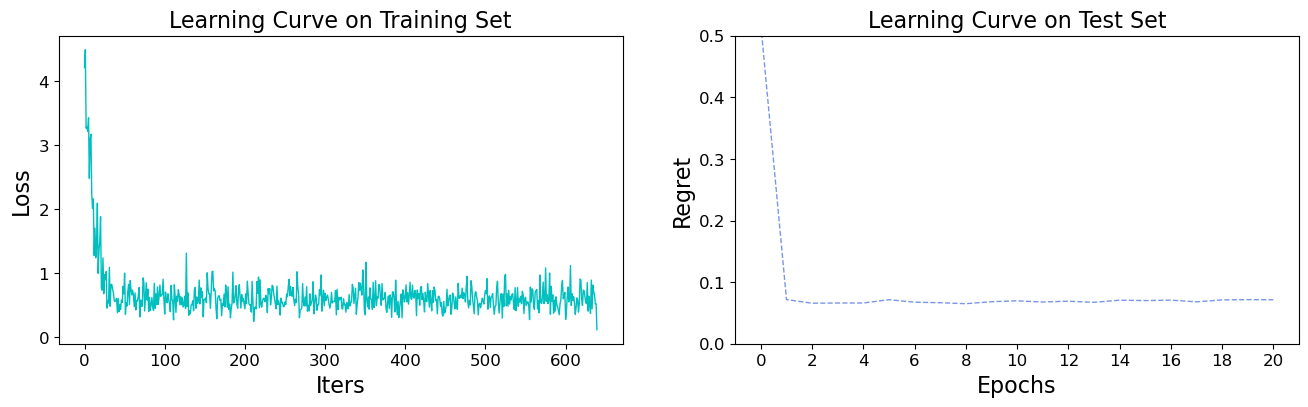

In [27]:
visLearningCurve(loss_log, loss_log_regret)

Differentiable Black-Box Solver

In [35]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.blackboxOpt`` allows us to set a differentiable solver, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``lambd``: a parameter to contral interpolation degree
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores

In [38]:
# init dbb solver
dbb = pyepo.func.blackboxOpt(optmodel, lambd=20, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function
def dbbl1(cp, c, z):
    # black-box optimizer
    wp = dbb(cp)
    # objective value
    zp = (wp * c).sum(1).view(-1, 1)
    # loss
    loss = l1(zp, z)
    return loss

Num of cores: 2


Entrenamiento

In [41]:
loss_log, loss_log_regret = trainModel(reg, loss_func=dbbl1, method_name="dbb")

Epoch  1,  Loss:    0.0523,  Regret: 15.7688%
Epoch  2,  Loss:    0.2143,  Regret: 10.1669%
Epoch  3,  Loss:    0.0321,  Regret:  8.8117%
Epoch  4,  Loss:    0.1493,  Regret:  8.1716%
Epoch  5,  Loss:    0.2399,  Regret: 12.5073%
Epoch  6,  Loss:    0.4410,  Regret: 12.6557%
Epoch  7,  Loss:    0.3106,  Regret: 12.2888%
Epoch  8,  Loss:    0.1481,  Regret: 12.9922%
Epoch  9,  Loss:    0.4448,  Regret: 16.8191%
Epoch 10,  Loss:    0.1266,  Regret: 16.4219%
Epoch 11,  Loss:    0.7160,  Regret: 15.1954%
Epoch 12,  Loss:    0.2310,  Regret: 15.4566%
Epoch 13,  Loss:    0.3147,  Regret: 12.7258%
Epoch 14,  Loss:    0.0337,  Regret: 12.6564%
Epoch 15,  Loss:    0.1989,  Regret: 15.5602%
Epoch 16,  Loss:    0.1930,  Regret: 12.8137%
Epoch 17,  Loss:    0.6126,  Regret: 17.5472%
Epoch 18,  Loss:    0.2274,  Regret: 13.0912%
Epoch 19,  Loss:    0.4261,  Regret: 21.2496%
Epoch 20,  Loss:    0.4802,  Regret: 13.4326%
Total Elapsed Time: 768.87 Sec.


Curva de aprendizaje

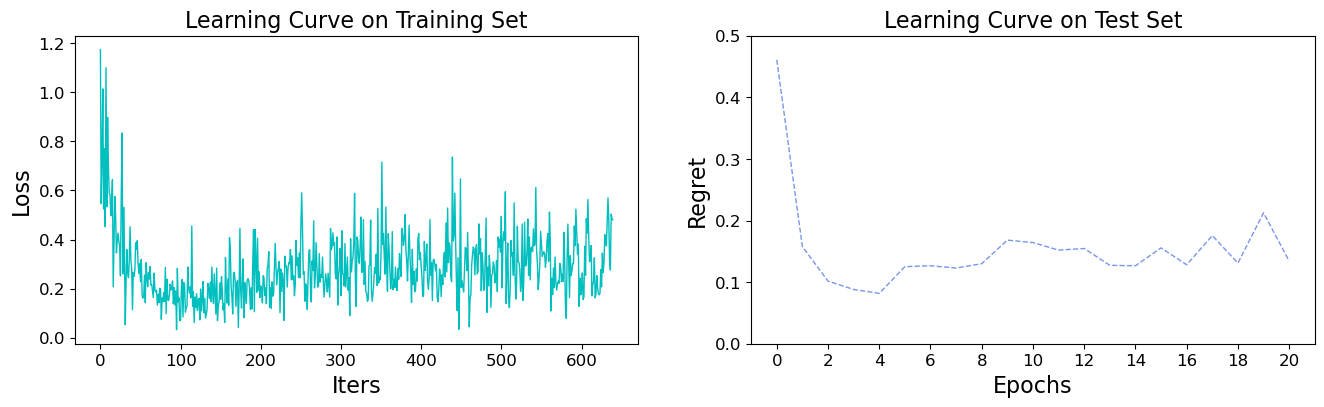

In [43]:
visLearningCurve(loss_log, loss_log_regret)

-Differentiable Perturbed Optimizer 

In [45]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.perturbedOpt`` allows us to set a SPO+ loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [47]:
# init ptb solver
ptb = pyepo.func.perturbedOpt(optmodel, n_samples=3, sigma=1.0, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function se tiene que definir un funcion de perdida ya que en ptb no viene incluida
def ptbl1(cp, w):
    # perturbed optimizer
    we = ptb(cp)
    # loss
    loss = l1(we, w)
    return loss

Num of cores: 2


In [48]:
loss_log, loss_log_regret = trainModel(reg, loss_func=ptbl1, method_name="ptb")

Epoch  1,  Loss:    0.2708,  Regret: 21.1431%
Epoch  2,  Loss:    0.3681,  Regret: 12.5813%
Epoch  3,  Loss:    0.2847,  Regret: 10.0164%
Epoch  4,  Loss:    0.1458,  Regret:  8.8509%
Epoch  5,  Loss:    0.2431,  Regret:  8.2321%
Epoch  6,  Loss:    0.4028,  Regret:  7.5788%
Epoch  7,  Loss:    0.2222,  Regret:  7.7732%
Epoch  8,  Loss:    0.3056,  Regret:  7.5640%
Epoch  9,  Loss:    0.0972,  Regret:  7.7163%
Epoch 10,  Loss:    0.0903,  Regret:  7.5095%
Epoch 11,  Loss:    0.2847,  Regret:  7.7058%
Epoch 12,  Loss:    0.1806,  Regret:  7.7789%
Epoch 13,  Loss:    0.2500,  Regret:  7.2179%
Epoch 14,  Loss:    0.1319,  Regret:  7.5765%
Epoch 15,  Loss:    0.2500,  Regret:  7.4557%
Epoch 16,  Loss:    0.2708,  Regret:  7.9224%
Epoch 17,  Loss:    0.2917,  Regret:  7.9158%
Epoch 18,  Loss:    0.1875,  Regret:  7.7024%
Epoch 19,  Loss:    0.2431,  Regret:  7.7638%
Epoch 20,  Loss:    0.1806,  Regret:  7.5280%
Total Elapsed Time: 730.37 Sec.


Curva de apredizaje

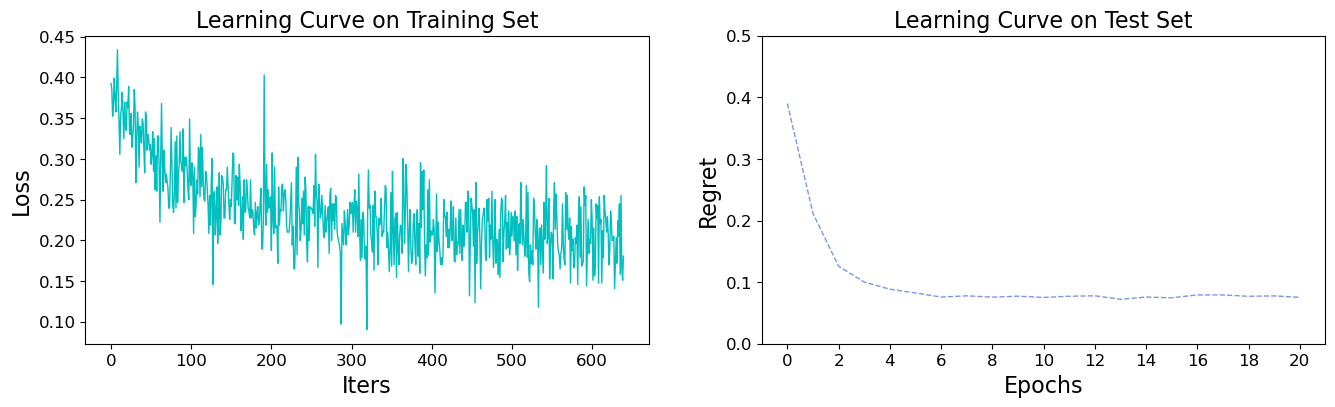

In [50]:
visLearningCurve(loss_log, loss_log_regret)

Perturbed Fenchel-Young Loss 

In [52]:
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=10, sigma=0.5, processes=2)

Num of cores: 2


In [53]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.perturbedFenchelYoung`` allows us to set a Fenchel-Young loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [55]:
# init pfyl loss
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0, processes=2)

Num of cores: 2


Entrenamiento

In [57]:
loss_log, loss_log_regret = trainModel(reg, loss_func=pfy, method_name="pfy")

Epoch  1,  Loss:    1.6944,  Regret:  8.9017%
Epoch  2,  Loss:    2.5000,  Regret:  7.2678%
Epoch  3,  Loss:    2.6111,  Regret:  7.2956%
Epoch  4,  Loss:    1.4167,  Regret:  7.2035%
Epoch  5,  Loss:    2.8611,  Regret:  6.9151%
Epoch  6,  Loss:    2.6111,  Regret:  7.0206%
Epoch  7,  Loss:    1.2500,  Regret:  6.7192%
Epoch  8,  Loss:    1.0278,  Regret:  7.1205%
Epoch  9,  Loss:    2.6111,  Regret:  6.8095%
Epoch 10,  Loss:    0.7222,  Regret:  6.8197%
Epoch 11,  Loss:    2.3056,  Regret:  6.6106%
Epoch 12,  Loss:    1.8889,  Regret:  6.7255%
Epoch 13,  Loss:    1.8333,  Regret:  6.9178%
Epoch 14,  Loss:    0.5000,  Regret:  6.4678%
Epoch 15,  Loss:    1.1944,  Regret:  6.8351%
Epoch 16,  Loss:    2.1389,  Regret:  6.6124%
Epoch 17,  Loss:    1.9722,  Regret:  6.8747%
Epoch 18,  Loss:    3.0833,  Regret:  6.8450%
Epoch 19,  Loss:    1.5556,  Regret:  7.1888%
Epoch 20,  Loss:    0.8611,  Regret:  7.0724%
Total Elapsed Time: 728.62 Sec.


Curva de aprendizaje

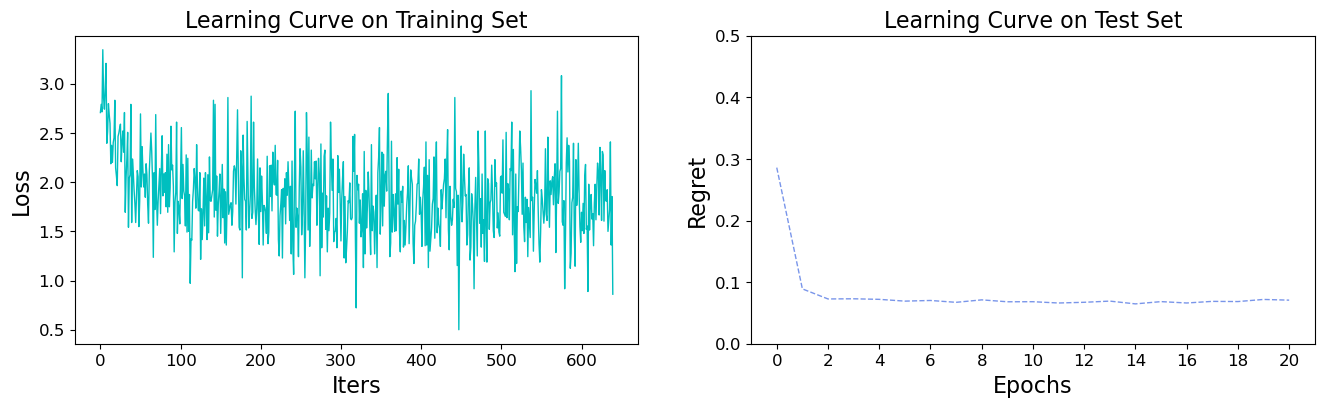

In [59]:
visLearningCurve(loss_log, loss_log_regret)